In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm
from scipy.stats import gaussian_kde

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device.type.upper()}")

Running on CUDA


In [14]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Mean and log variance for weight and bias distributions
        self.mu_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        
        self.mu_bias = nn.Parameter(torch.Tensor(out_features))
        self.log_sigma_bias = nn.Parameter(torch.Tensor(out_features))
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.mu_weight)
        self.log_sigma_weight.data.fill_(-5)
        self.mu_bias.data.zero_()
        self.log_sigma_bias.data.fill_(-5)
    
    def forward(self, input):
        # Sample weights and biases from normal distributions
        weight = self.mu_weight + torch.exp(self.log_sigma_weight) * torch.randn_like(self.log_sigma_weight)
        bias = self.mu_bias + torch.exp(self.log_sigma_bias) * torch.randn_like(self.log_sigma_bias)
        return F.linear(input, weight, bias)


In [15]:
class BayesianRealNVPBlock(nn.Module):
    def __init__(self, in_features, hidden_features):
        super(BayesianRealNVPBlock, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features

        self.net_s = self._build_bayesian_network()
        self.net_t = self._build_bayesian_network()

    def _build_bayesian_network(self):
        return nn.Sequential(
            BayesianLinear(self.in_features // 2, self.hidden_features),
            nn.ReLU(),
            BayesianLinear(self.hidden_features, self.hidden_features * 2),
            nn.ReLU(),
            BayesianLinear(self.hidden_features * 2, self.hidden_features * 2),
            nn.ReLU(),
            BayesianLinear(self.hidden_features * 2, self.hidden_features),
            nn.ReLU(),
            BayesianLinear(self.hidden_features, self.in_features // 2),
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        s = self.net_s(x_a)
        t = self.net_t(x_a)
        y_a = x_a
        y_b = x_b * torch.exp(s) + t
        log_det_jacobian = s.sum(dim=1)
        return torch.cat([y_a, y_b], dim=1), log_det_jacobian

    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.net_s(y_a)
        t = self.net_t(y_a)
        x_a = y_a
        x_b = (y_b - t) * torch.exp(-s)
        return torch.cat([x_a, x_b], dim=1)

In [16]:
class BayesianRealNVP(nn.Module):
    def __init__(self, num_blocks, in_features, hidden_features):
        super(BayesianRealNVP, self).__init__()
        self.blocks = nn.ModuleList([BayesianRealNVPBlock(in_features, hidden_features) for _ in range(num_blocks)])
        self.prior = distributions.MultivariateNormal(torch.zeros(in_features).to(device), torch.eye(in_features).to(device))

    def forward(self, x):
        log_det_jacobian = 0
        for block in self.blocks:
            x, ldj = block.forward(x)
            log_det_jacobian += ldj
            x = torch.flip(x, dims=(1,))
        return x, log_det_jacobian

    def backward(self, y):
        for block in reversed(self.blocks):
            y = torch.flip(y, dims=(1,))
            y = block.backward(y)
        return y

    def log_prob(self, x):
        y, log_det_jacobian = self.forward(x)
        log_prob_z = self.prior.log_prob(y)
        return log_prob_z + log_det_jacobian

    def sample(self, batch_size):
        y = self.prior.sample((batch_size,))
        x = self.backward(y)
        return x


In [17]:
def check_for_nan(tensor, name=""):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

In [18]:
def plot_samples(samples, title, dim=2):
    samples = samples.detach().numpy()
    if dim == 2:
        plt.figure(figsize=(8, 8))
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
        plt.title(title)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()
        
    elif dim == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
        plt.show()

def plot_comparison(original_samples, generated_samples, title, dim=2):
    original_samples = original_samples.detach().numpy()
    generated_samples = generated_samples.detach().numpy()
    if dim == 2:
        plt.figure(figsize=(8, 8))
        plt.scatter(original_samples[:, 0], original_samples[:, 1], alpha=0.5, label='Original')
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated')
        plt.title(title)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(original_samples[:, 0], original_samples[:, 1], original_samples[:, 2], alpha=0.5, label='Original')
        ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], alpha=0.5, label='Generated')
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
        ax.legend()
        plt.show()

In [19]:
def train_bayesian_realnvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, num_samples):
    best_val_loss = float('inf')
    best_model_weights = None
    train_loss = []
    val_loss = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            x = batch[0].to(device)  # Access the tensor directly
            optimizer.zero_grad()
            loss = -model.log_prob(x).mean()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # Validation loss calculation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)  # Access the tensor directly
                val_loss_batch = -model.log_prob(x).mean()
                total_val_loss += val_loss_batch.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict().copy()

        

        if epoch + 1 in visualize_epochs:
            with torch.no_grad():
                print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
                # Visualization of samples from learned distribution
                generated_samples = model.sample(num_samples).cpu()
                plot_samples(generated_samples[:, :2], f'Generated_Samples_at_Epoch_{epoch + 1}', dim=2)

    # Restore best model weights
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), "best_bayesian_realnvp_model.pth")

    return train_loss, val_loss

In [20]:
def prepare_data(train_split=0.8, batch_size=256):
    X, _ = make_moons(n_samples=1000, noise=0.1)
    X = torch.tensor(X, dtype=torch.float32)

    dataset = torch.utils.data.TensorDataset(X)
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, X

In [21]:
def compute_data_overlap(original_samples, generated_samples, bandwidth='scott'):
    """
    Computes the probability of overlap between original and generated samples.

    Parameters:
    - original_samples (torch.Tensor): Tensor of original data samples.
    - generated_samples (torch.Tensor): Tensor of generated data samples.
    - bandwidth (str or float): The bandwidth of the kernel. 'scott' or 'silverman' can be used for automatic selection, or specify a float value.

    Returns:
    - overlap_probability (float): The computed probability of overlap between the original and generated samples.
    """
    # Convert samples to numpy for KDE
    original_samples_np = original_samples.detach().numpy().T
    generated_samples_np = generated_samples.detach().numpy().T

    # Ensure both arrays have the same number of samples by sampling the smaller set
    min_samples = min(original_samples_np.shape[1], generated_samples_np.shape[1])
    original_samples_np = original_samples_np[:, np.random.choice(original_samples_np.shape[1], min_samples, replace=False)]
    generated_samples_np = generated_samples_np[:, np.random.choice(generated_samples_np.shape[1], min_samples, replace=False)]

    # Create KDEs for both distributions
    kde_original = gaussian_kde(original_samples_np, bw_method=bandwidth)
    kde_generated = gaussian_kde(generated_samples_np, bw_method=bandwidth)

    # Evaluate the KDEs over the same grid
    sample_points = np.hstack([original_samples_np, generated_samples_np])

    original_density = kde_original(sample_points)
    generated_density = kde_generated(sample_points)

    # Compute overlap as the minimum density at each point
    overlap_density = np.minimum(original_density, generated_density)

    # Integrate the overlap density to get the total overlap probability
    overlap_probability = np.sum(overlap_density) / np.sum(kde_original(sample_points))

    return overlap_probability

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Training Loss: 2.1407, Validation Loss: 5.6557


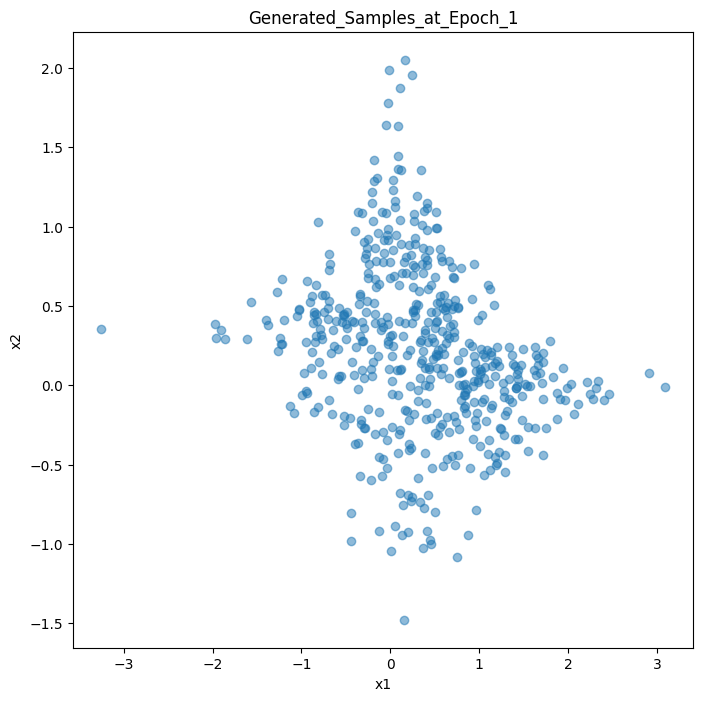

  9%|▉         | 9/100 [00:01<00:10,  9.06it/s]

Epoch 10/100, Training Loss: 1.7192, Validation Loss: 1.7289


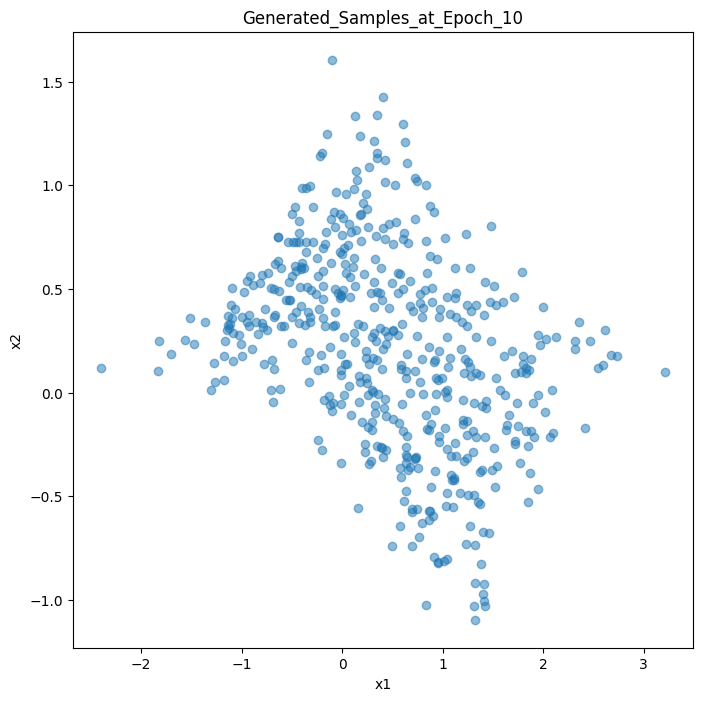

 49%|████▉     | 49/100 [00:05<00:05,  8.99it/s]

Epoch 50/100, Training Loss: 1.3897, Validation Loss: 1.3593


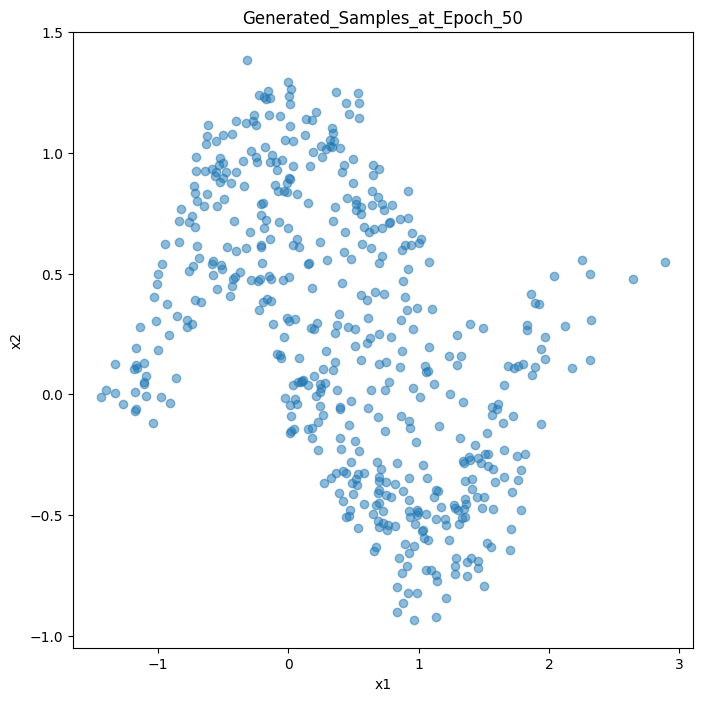

 99%|█████████▉| 99/100 [00:10<00:00, 10.80it/s]

Epoch 100/100, Training Loss: 1.2499, Validation Loss: 1.4695


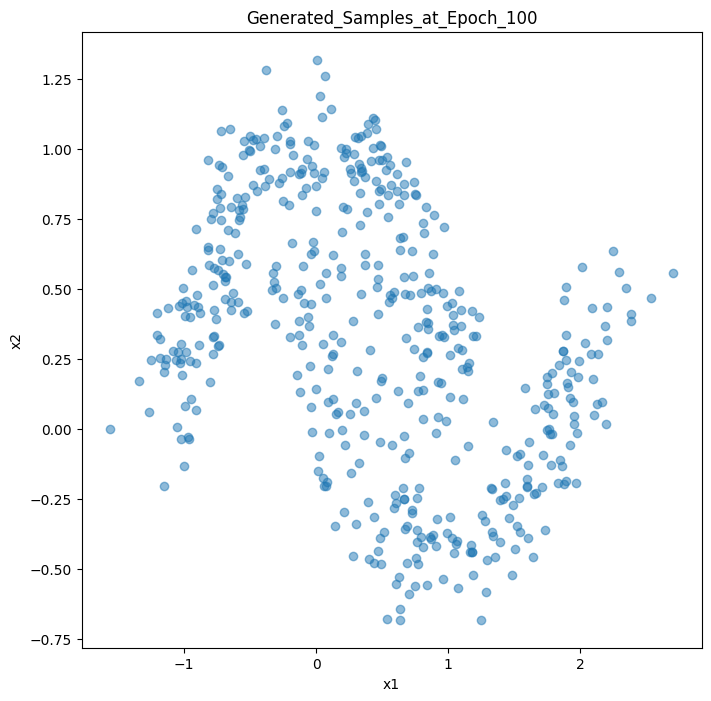

100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


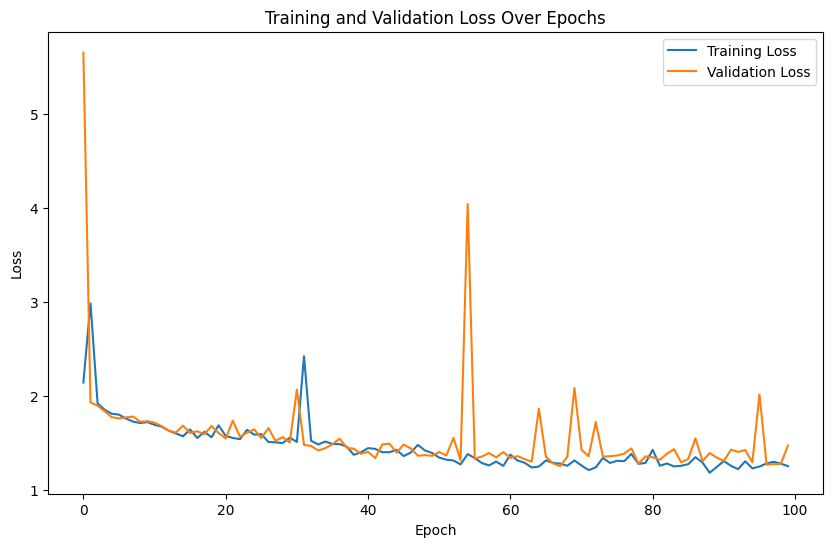

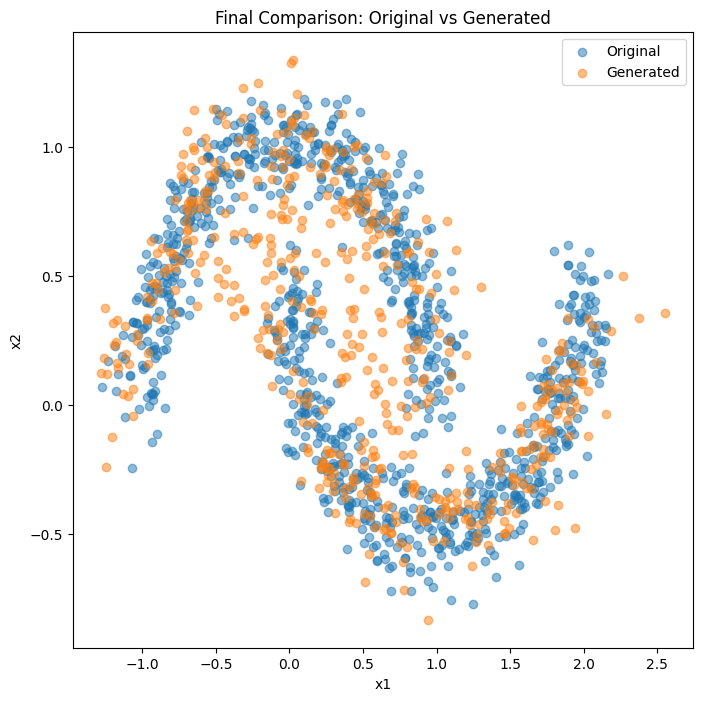

Final probability of data overlap: 0.9154


In [22]:
in_features = 2
hidden_features = 128
num_blocks = 4
learning_rate = 1e-3
num_epochs = 100
visualize_epochs = [1, 10, 50, 100]

batch_size = 256
num_samples = 500

# Preparing data
train_loader, val_loader, original_samples = prepare_data()

# Model, optimizer, and scheduler
model = BayesianRealNVP(num_blocks=num_blocks, in_features=in_features, hidden_features=hidden_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# Training the model
train_loss, val_loss = train_bayesian_realnvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, num_samples)

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"/home/fedja-mocnik/Documents/IJS/slike_model/Pierre/12d/Loss_plot.png")
plt.show()

# Plotting final results
with torch.no_grad():
    generated_samples = model.sample(num_samples).cpu()
    plot_comparison(original_samples[:, :2], generated_samples[:, :2], "Final Comparison: Original vs Generated", dim=2)


# Example usage after training:
with torch.no_grad():
    generated_samples = model.sample(num_samples).cpu()
    overlap_probability = compute_data_overlap(original_samples[:, :2], generated_samples[:, :2])
    print(f"Final probability of data overlap: {overlap_probability:.4f}")